![](../doc/pics/GPK_BME_MOGI.png)
# Attention training
In this notebook a Dense Deep neural network is trained to recognise the dog's focus of attention. The network is implemented with the help of Tensorflow Keras. 

Notebook written by András Zöllner, [zollner.andras@gmail.com](mailto:zollner.andras@gmail.com)

## Importing the needed tools
Firstly the tensorflow and data processing tools are imported

In [1]:
#tensorflow imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import History, EarlyStopping

#plotter import
import matplotlib.pyplot as plt

#dataporcess imports
from dataprocess import *

## Loading and preprocessing measurement data

In [2]:
#loading the data from files and consturcting the myData EtoData instance
mocapy_file = "../log/Husky_02-processed [MISLABELED EPISODES].csv" #path of the mocapy csv file
video_file = "../log/vid_tags_time_refined.csv" #path of the solomon coder csv file
myData = EtoData(mocapy_file,video_file) #consturct the myData instace of the EtoData class

In [3]:
print(myData.mocapy_preproc_head)
print(myData.solomon_preproc_head)

['Episode counter', 'DOG_pos_X', 'DOG_pos_Y', 'DOG_pos_Z', 'DOG_rot_Z', 'DOG_tracked', 'DOG_has_toy', 'OWN_pos_X', 'OWN_pos_Y', 'OWN_pos_Z', 'OWN_rot_Z', 'OWN_tracked', 'OWN_is_in_room', 'OWN_has_toy', 'OHA_pos_X', 'OHA_pos_Y', 'OHA_pos_Z', 'OHA_rot_Z', 'OHA_tracked', 'STR_pos_X', 'STR_pos_Y', 'STR_pos_Z', 'STR_rot_Z', 'STR_tracked', 'STR_is_in_room', 'STR_has_toy', 'SHA_pos_X', 'SHA_pos_Y', 'SHA_pos_Z', 'SHA_rot_Z', 'SHA_tracked', 'TOY_pos_X', 'TOY_pos_Y', 'TOY_pos_Z', 'TOY_rot_Z', 'TOY_tracked', 'DOOR_pos_X', 'DOOR_pos_Y', 'DOOR_pos_Z', 'DOOR_rot_Z', 'DOOR_tracked', 'DOOR_is_open', 'WAND_pos_X', 'WAND_pos_Y', 'WAND_pos_Z', 'WAND_rot_Z', 'WAND_tracked', 'OWN_d', 'OWN_r', 'OHA_d', 'OHA_r', 'STR_d', 'STR_r', 'SHA_d', 'SHA_r', 'TOY_d', 'TOY_r', 'DOOR_d', 'DOOR_r']
['Attention', 'Contact', 'Contact Seeking', 'Tail']


The neural network's input will be the following:
- owner's, stranger's and their hand's distance from dog and their relative rotation measured from the dog's direction
- owner, stranger: is in room ? has toy ? 
- toy, door: distance from dog, relative rotation from the dog's direction
- door is open ?
- toy tracked ? (is in room ?)

In [4]:
data = myData.get_preproc_cols(col_names=["OWN_d", "OWN_r", "OHA_d", "OHA_r", "OWN_is_in_room", "OWN_has_toy", "STR_d", "STR_r", "SHA_d", "SHA_r", "STR_is_in_room", "STR_has_toy", "TOY_d", "TOY_r", "TOY_tracked", "DOOR_d", "DOOR_r", "DOOR_is_open", "Attention"])
print(data.shape)

(47590, 19)


## Separation of tagged data
We separate the tagged data into training, validation and test data.

![Data segments](../doc/pics/segments.png)

In [5]:
#separating training and validation data
data_train = np.array([]).reshape((-1, data.shape[1]))
data_val = np.array([]).reshape((-1, data.shape[1]))
data_test = np.array([]).reshape((-1, data.shape[1]))

#we need training and validation data from every scene (7 scenes total)
#num_divs should be divisible by 7
num_divs = 6*7
divlen = int(np.floor(len(data)/num_divs))
train_len = int(np.floor(0.6*divlen))
val_len = int(np.floor(0.2*divlen))

for i in range(num_divs):
    if i == (num_divs-1):
        div = data[(i*divlen):,:]
    else:
        div = data[(i*divlen):((i+1)*divlen),:]
    data_train = np.append(data_train, div[0:train_len,:], axis=0)
    data_val = np.append(data_val, div[train_len:(train_len+val_len),:], axis=0)
    data_test = np.append(data_test, div[(train_len+val_len):len(div),:], axis=0)
    
print(data_train.shape)
print(data_val.shape)
print(data_test.shape)
print(len(data_train) + len(data_val) + len(data_test))
print(len(data))
print(divlen)
print(train_len)
print(val_len)

(28518, 19)
(9492, 19)
(9580, 19)
47590
47590
1133
679
226


In [6]:
#separating the inputs and outputs (outputs are int32, inputs are float32)
x_train = data_train[:,0:-1].copy().astype("float32")
y_train = data_train[:,-1].copy().astype("int")
x_val = data_val[:,0:-1].copy().astype("float32")
y_val = data_val[:,-1].copy().astype("int")
x_test = data_test[:,0:-1].copy().astype("float32")
y_test = data_test[:,-1].copy().astype("int")

## Creating and training the neural network

In [7]:
#creating a keras neural network (Sequential API)
model = keras.Sequential([
    keras.Input(shape=(x_train.shape[1])),
    layers.Dense(50, activation="relu"),
    layers.Dense(50, activation="relu"),
    layers.Dense(25, activation="relu"),
    layers.Dense(25, activation="relu"),
    layers.Dense(25, activation="relu"),
    layers.Dense(10, activation="relu"),
    layers.Dense(10, activation="relu"),
    layers.Dense(10, activation="relu"),
    layers.Dense(10, activation="relu"),
    layers.Dense(5)
])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                950       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_3 (Dense)              (None, 25)                650       
_________________________________________________________________
dense_4 (Dense)              (None, 25)                650       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                260       
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1

In [8]:
#compiling the model
learning_rate = 0.001
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(lr=learning_rate),
    metrics=["accuracy"], 
)
hist = History()
earlystop = EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=10, verbose=1,
    mode='max', restore_best_weights=True)

In [9]:
#training the model
num_epochs = 40
model.fit(x_train, y_train, batch_size=32, epochs=num_epochs, validation_data=(x_val,y_val), callbacks=[hist,earlystop])

Epoch 1/40
892/892 [==============================] - 3s 2ms/step - loss: 1.0529 - accuracy: 0.5666 - val_loss: 0.7909 - val_accuracy: 0.7017
Epoch 2/40
892/892 [==============================] - 1s 1ms/step - loss: 0.4602 - accuracy: 0.8474 - val_loss: 0.7471 - val_accuracy: 0.7590
Epoch 3/40
892/892 [==============================] - 1s 1ms/step - loss: 0.3205 - accuracy: 0.8939 - val_loss: 0.9377 - val_accuracy: 0.7506
Epoch 4/40
892/892 [==============================] - 1s 1ms/step - loss: 0.2456 - accuracy: 0.9184 - val_loss: 1.1711 - val_accuracy: 0.7228
Epoch 5/40
892/892 [==============================] - 1s 1ms/step - loss: 0.2174 - accuracy: 0.9259 - val_loss: 1.1745 - val_accuracy: 0.7412
Epoch 6/40
892/892 [==============================] - 1s 1ms/step - loss: 0.2020 - accuracy: 0.9329 - val_loss: 1.1733 - val_accuracy: 0.7486
Epoch 7/40
892/892 [==============================] - 1s 1ms/step - loss: 0.1656 - accuracy: 0.9476 - val_loss: 1.2489 - val_accuracy: 0.7540
Epoch 

## Evalutation of the trained network

In [10]:
#evaluating prediction for test data
model.evaluate(x_test, y_test, batch_size=32)

300/300 [==============================] - 0s 733us/step - loss: 0.9384 - accuracy: 0.7590


[0.9384303689002991, 0.7589770555496216]

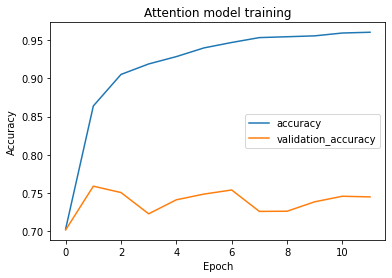

In [11]:
plt.plot(hist.history["accuracy"],label="accuracy")
plt.plot(hist.history["val_accuracy"],label="validation_accuracy")
plt.title("Attention model training")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Saving the created neural network

In [12]:
#saving the model
model.save("../models/attention_model")

INFO:tensorflow:Assets written to: ../models/attention_model\assets
